In [2]:
import sys
import numpy as np
from matplotlib import pyplot as plt
sys.path.append('..')
from utils.data import Subject, load_participant_list
from utils.analysis import compute_parametric_modulator

In [3]:
base_dir = '/home/ubuntu/data/learning-habits'
sub_ids = load_participant_list(base_dir)

In [4]:
subjects = [Subject(base_dir, sub_id, include_modeling=True, include_imaging=False) for sub_id in sub_ids]

/home/ubuntu/repos/learning-habits-analysis/notebooks/../utils/data.py:178: UserWarning: Last 1 trial(s) of block had no response, filling with 0


In [5]:
df = subjects[0].extended_trials
df.head()

,block,left_stim,right_stim,left_value,right_value,shift,action,rt,chosen_stim,reward,...,stim1_prop_training,stim2_prop_training,stim_diff_prop_training,stim_diff_prop_training_chosen,reward1C,stim_diff_prop_trainingS,stim_diff_prop_training_chosenS,diff_valS,diff_val_chosenS,score_EHI
0,learning1,5,7,3,4,0,1.0,0.934432,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,learning1,4,6,3,4,1,1.0,0.645392,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,learning1,3,1,2,1,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,learning1,6,8,4,5,0,1.0,0.368762,6.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,learning1,2,4,2,3,0,1.0,0.537730,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
rl_cols = [col for col in df.columns if col.startswith('stim') and col.endswith('_value_rl')]
ck_cols = [col for col in df.columns if col.startswith('stim') and col.endswith('_value_ck')]

In [7]:
RL_values = np.zeros((len(subjects), len(df), len(rl_cols)))
CK_values = np.zeros((len(subjects), len(df), len(ck_cols)))

In [8]:
for i, sub in enumerate(subjects):
    RL_values[i] = sub.extended_trials[rl_cols].values
    CK_values[i] = sub.extended_trials[ck_cols].values

In [9]:
from itertools import cycle
def plot_mean_sem_stimuli(data, axis=None, colors=None, labels=None, alpha=0.3):
    """
    Plots mean ± SEM timecourses for each stimulus.

    Parameters:
    - data: 3D array of shape (n_subjects, n_timepoints, n_stimuli)
    - axis: matplotlib axis (optional)
    - colors: list of colors for each stimulus (optional)
    - labels: list of labels for each stimulus (optional)
    - alpha: transparency for shaded area
    """
    if axis is None:
        axis = plt.gca()

    n_subjects, n_timepoints, n_stimuli = data.shape
    timepoints = np.arange(n_timepoints)

    color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

    for i in range(n_stimuli):
        stim_data = data[:, :, i]
        mean = np.mean(stim_data, axis=0)
        sem = np.std(stim_data, axis=0, ddof=1) / np.sqrt(n_subjects)

        color = next(color_cycle)
        label = labels[i] if labels else f'Stimulus {i+1}'

        axis.plot(timepoints, mean, color=color, label=label)
        axis.fill_between(timepoints, mean - sem, mean + sem, color=color, alpha=alpha)

    axis.set_xlabel('Time (TRs)')
    axis.set_ylabel('Signal (a.u.)')
    return axis

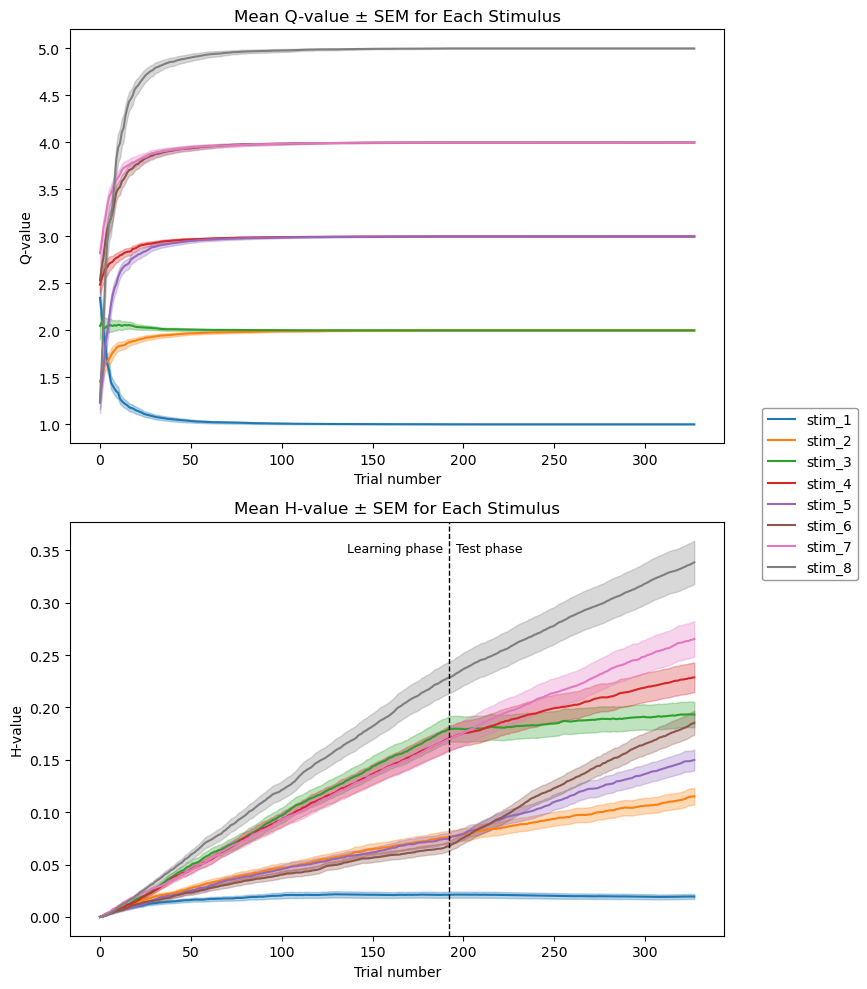

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

# Q-values subplot
plot_mean_sem_stimuli(
    RL_values,
    axis=axs[0],
    labels=['stim_' + str(i) for i in range(1, RL_values.shape[2] + 1)]
)
axs[0].set_xlabel('Trial number')
axs[0].set_ylabel('Q-value')
axs[0].set_title('Mean Q-value ± SEM for Each Stimulus')

# H-values subplot
plot_mean_sem_stimuli(
    CK_values,
    axis=axs[1],
    labels=['stim_' + str(i) for i in range(1, CK_values.shape[2] + 1)]
)
axs[1].set_xlabel('Trial number')
axs[1].set_ylabel('H-value')
axs[1].set_title('Mean H-value ± SEM for Each Stimulus')

# Add vertical line at trial 196
axs[1].axvline(x=192, color='black', linestyle='--', linewidth=1)
axs[1].text(136, axs[1].get_ylim()[1] * 0.95, 'Learning phase', fontsize=9, verticalalignment='top')
axs[1].text(196, axs[1].get_ylim()[1] * 0.95, 'Test phase', fontsize=9, verticalalignment='top')

# Create shared legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='center left',
    bbox_to_anchor=(0.95, 0.5),
    frameon=True
).get_frame().set_edgecolor('gray')

plt.tight_layout(rect=[0, 0, 0.93, 1])  # leave space for legend
plt.show()

In [27]:
C = np.zeros((RL_values.shape[0],))
for s in range(RL_values.shape[0]):
    C[s] = np.corrcoef(RL_values[s,...].flatten(), CK_values[s,...].flatten())[0,1]

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


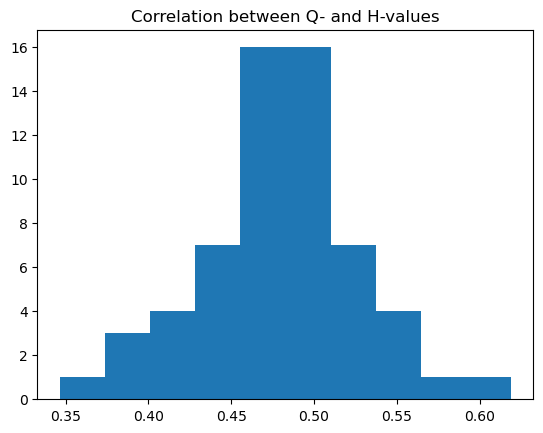

In [28]:
plt.hist(C, density=False)
plt.title('Correlation between Q- and H-values')
plt.show()

# Excluding highest/lowest stimuli

In [29]:
# excluding lowest and highest value stimuli:
rl_cols = rl_cols[1:-1]
ck_cols = ck_cols[1:-1]

In [30]:
RL_values = np.zeros((len(subjects), len(df), len(rl_cols)))
CK_values = np.zeros((len(subjects), len(df), len(ck_cols)))

In [31]:
for i, sub in enumerate(subjects):
    RL_values[i] = sub.extended_trials[rl_cols].values
    CK_values[i] = sub.extended_trials[ck_cols].values

Text(0.5, 1.0, 'H-values')

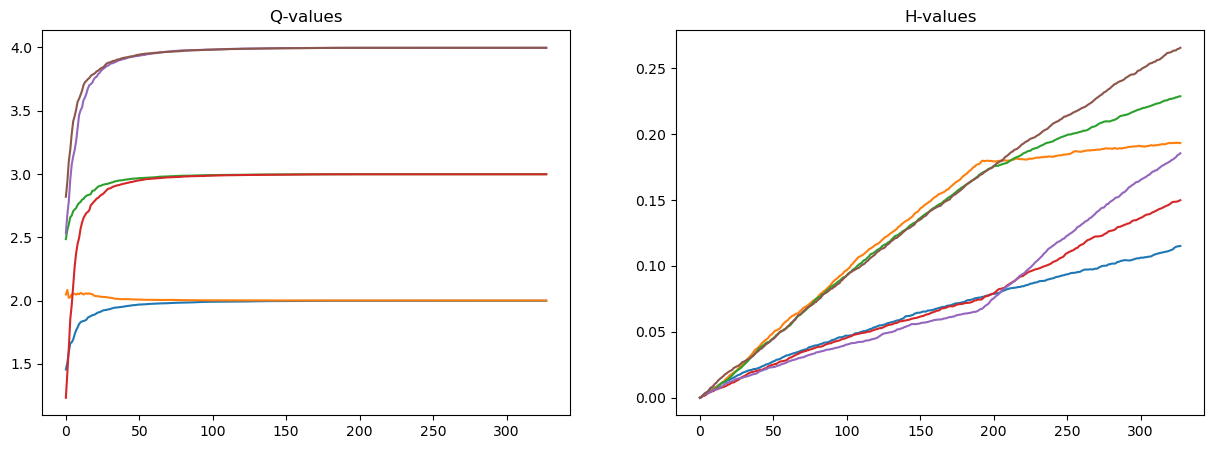

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(RL_values.mean(axis=0))
axs[0].set_title('Q-values')
axs[1].plot(CK_values.mean(axis=0))
axs[1].set_title('H-values')

In [33]:
C = np.zeros((RL_values.shape[0],))
for s in range(RL_values.shape[0]):
    C[s] = np.corrcoef(RL_values[s,...].flatten(), CK_values[s,...].flatten())[0,1]

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


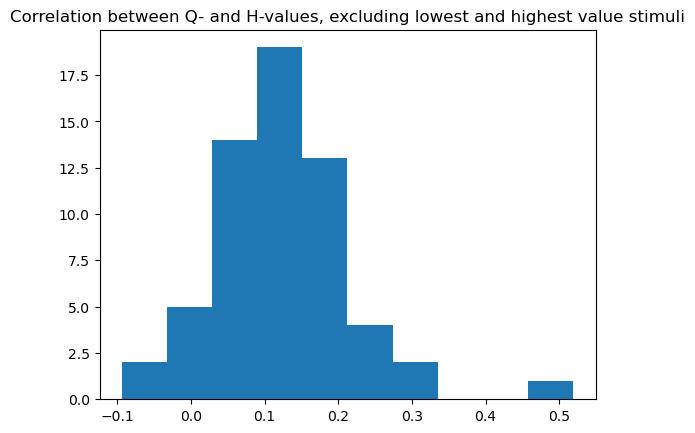

In [34]:
plt.hist(C, density=False)
plt.title('Correlation between Q- and H-values, excluding lowest and highest value stimuli')
plt.show()